<a href="https://colab.research.google.com/github/iremnuy/Adversary_Attack_Resnet/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MI201 : attaque sur réseau de neurones à convolution**

---

# 1. Mise en place
Importation des bibliothèques et mise en place du GPU :

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


import os
import torch
import torchvision
import torch.nn.functional as F

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


On importe des images à classer :

<ipython-input-2-1a7855e3c93b>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  img = torch.load("coco_sample.pth")


torch.Size([9, 3, 520, 520])


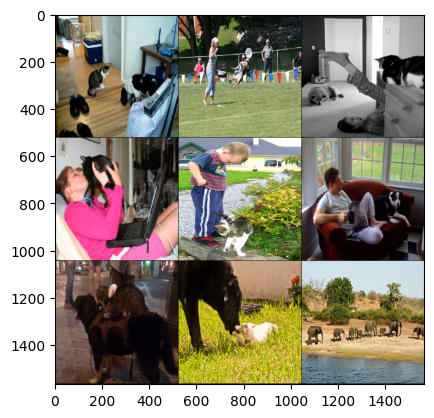

In [ ]:
if not os.path.isfile("coco_sample.pth"):
  os.system("wget https://httpmail.onera.fr/21/050a4e5c4611d260c1b8035b5dc8617eO1A12h/coco_sample.pth")

img = torch.load("coco_sample.pth")
print(img.shape) # [9,3,520,520] donc 9 images avec 3 canaux et 520*520px

visu = torchvision.utils.make_grid(img,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.show()

On peut ensuite importer le réseau et ses poids pré-entrainés sur coco :

In [ ]:
W = torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1
net = torchvision.models.segmentation.deeplabv3_resnet50(weights=W).eval().to(device) #on charge un resnet50 avec des poids pré entrainés en mode évaluation et on l'envoie au GPU

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 171MB/s]


A titre de comparaison, et pour récupérer des étiquettes fiables, on classe nos images une première fois



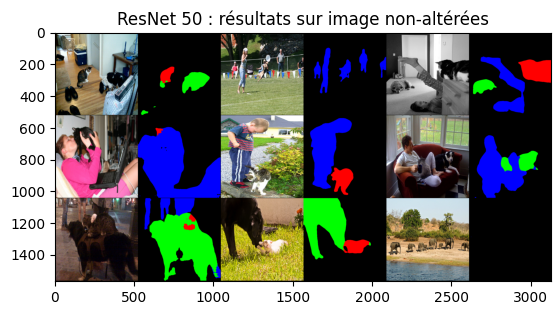

In [ ]:
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
unnormalize = torchvision.transforms.Normalize( #dénormalisation
    [-0.485/0.229, -0.456/0.224, -0.406/0.225],  # -mean/std
    [1/0.229, 1/0.224, 1/0.225]                   # 1/std
)



with torch.no_grad():
  img = img.to(device)
  z = net(normalize(img))["out"] # on prédit des cartes de score de confiance
  z = z[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,z = z.max(1) # on prend le meilleur score

# visualisation des prédictions : il faut transformer les indices de classes en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (z==1).float() # red for cat
pred[:,1,:,:] = (z==2).float() # green for dog
pred[:,2,:,:] = (z==3).float() # blue for person

visu = torch.cat([img.cpu(),pred],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.title("ResNet 50 : résultats sur image non-altérées")
plt.show()


#2.Construction de l'attaque sur un seul réseau

##Question 1: attaque "untargeted"
Dans un premier temps, on va simplement chercher à perturber au maximum la prédiction.
on calcule donc l'entropie croisée entre les prédictions faites précédement **z**, qu'on sait être plutôt proches de la réalité, et un nouveau tenseur de prédictions **Znoised** qu'on va prédire à partir de l'image originelle à laquelle on ajoute un tenseur de bruit.

On calcul le gradient à partir de cette fonction de perte, qu'on réduit ensuite uniquement à son signe.

Le tenseur de bruit est l'unique argument de l'optimiseur, qui va donc faire un pas d'une descente de gradient.

La dernière étape est de garantir que le bruit reste dans certaines limites : on veut qu'il ne soit pas trop élevé, on le restreint donc dans l'intervalle [-epsilon,epsilon] où epsilon est un hyperparamètre.

On s'assure également qu'une fois ajouté à l'image originale le résultat reste dans les limites attendues pour une image (entre 0 et 1).

##Question 2 : attaque "targeted"
Pour une attaque ciblée, nous calculons la perte comme la perte d'entropie croisée entre le label prédit et le label ciblé (target_class). Ce faisant, nous désorientons le réseau pour qu'il prédise chaque objet comme appartenant à la classe cible. Dans notre code, target_class est défini à 1, correspondant à la classe "chat", donc la segmentation de l'image attaquée sera colorée en rouge, quelle que soit la classe réelle de l'objet. Ainsi, la seule différence avec l'attaque non ciblée réside dans la formule de calcul de la perte.



tensor(161.4003, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


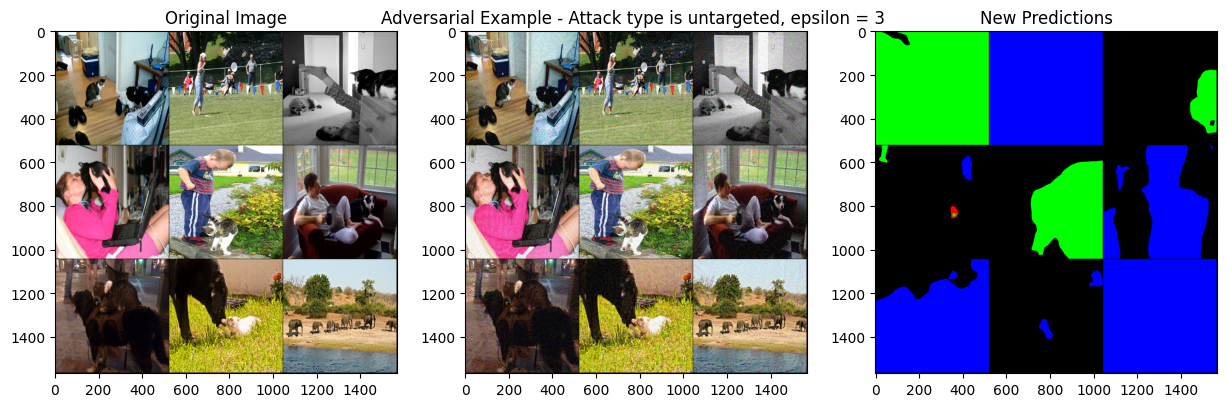

In [ ]:
def comparePlot(row, maxRows, epsilon):
  # Visualize original image
  plt.figure(figsize=(15, 5))  # Adjust the figure size for clarity
  plt.subplot(1, 3, 1)
  plt.title("Original Image")
  plt.imshow(torchvision.utils.make_grid((img), nrow=3).permute(1, 2, 0).cpu().numpy() )# Ensure .cpu() for visualization



  # Visualize adversarial example
  plt.subplot(1, 3, 2)
  plt.title(f"Adversarial Example - Attack type is {attack_type}, epsilon = {epsilon} ")
  print(attaque.norm())
  plt.imshow(torchvision.utils.make_grid(img + attaque, nrow=3).permute(1, 2, 0).cpu().numpy())

  # Visualize new predictions
  with torch.no_grad():
      new_preds = net((normalize(img + attaque)).to(device))["out"]
      new_preds = new_preds[:, [0, 8, 12, 15], :, :].argmax(1)  # Extract new class predictions

  # Convert predictions to RGB for visualization
  new_pred_colors = torch.zeros_like(img)  # Start with a blank image, use `x` instead of `img`
  new_pred_colors[:, 0, :, :] = (new_preds == 1).float()  # Red for "cat"
  new_pred_colors[:, 1, :, :] = (new_preds == 2).float()  # Green for "dog"
  new_pred_colors[:, 2, :, :] = (new_preds == 3).float()  # Blue for "person"

  plt.subplot(1, 3, 3)
  plt.title("New Predictions")
  plt.imshow(torchvision.utils.make_grid(new_pred_colors, nrow=3).permute(1, 2, 0).cpu().numpy())  # Ensure .cpu() for visualization

comparePlot(1,1,3)
plt.show()


In [ ]:
def attack_learn(epsilon, atk_tensor, optimizer, attack_type='targeted', num_iterations=10, target_class=1):
  for i in range(num_iterations):

    # Forward pass with the current perturbation
    Znoised = net(normalize(img + atk_tensor).to(device))["out"]
    Znoised = Znoised[:, [0, 8, 12, 15], :, :]  # Keep background, person, cat, and dog

    # Flatten labels and predictions for loss computation
    z_flat = z.view(-1)  # Ground truth labels
    Znoised_flat = Znoised.permute(0, 2, 3, 1).reshape(-1, Znoised.size(1))  # Logits reshaped for CrossEntropyLoss

    # Define the loss function (CrossEntropyLoss for untargeted, or MSE for targeted)
    if attack_type == 'targeted':
      target = torch.full_like(z_flat, target_class)  # Set the target class for the attack (e.g., cat)
      L = F.cross_entropy(Znoised_flat, target.view(-1))  # Targeted attack using CrossEntropyLoss
    elif attack_type == 'untargeted':
      L = -F.cross_entropy(Znoised_flat, z_flat)  # Untargeted attack: Maximize loss (minimize negative loss)

    # Zero gradients from the previous step

    optimizer.zero_grad()

    # calculates loss gradients and stores them in attaque
    L.backward()

    # Update perturbation based on gradient sign (sign attack)
    # Apply optimization step
    with torch.no_grad():

      atk_tensor.grad = atk_tensor.grad.sign()
      optimizer.step()

      # Clip the perturbation to keep it within an acceptable range (bounded by epsilon)
      atk_tensor.data = torch.clamp(atk_tensor.data, -epsilon, epsilon)

      # Ensure the perturbation stays within valid bounds relative to the original image
      lowbound = -img
      uppbound = 1 - img
      atk_tensor.data = torch.max(torch.min(atk_tensor.data, uppbound), lowbound)
      #attaque.data = lowbound*(attaque.data<lowbound).float() + uppbound*(attaque.data>uppbound).float() + attaque.data *(attaque.data>=lowbound).float()*(attaque.data<=uppbound).float()
  return L.item()


def epsilon_compare(epsilon_list, atk_tensor, optimizer, attack_type='targeted', num_iterations=10, target_class=1):
  losses=[]
  for i in range(len(epsilon_list)):
    eps = epsilon_list[i]
    atk_tensor = torch.nn.Parameter(torch.zeros_like(img),requires_grad=True)  # on réinitialise le tenseur d'attaque
    losses.append(attack_learn(eps, atk_tensor, optimizer, attack_type, num_iterations, target_class))
    print(losses[-0]);
    comparePlot(i+1,len(epsilon_values),eps)


  plt.show()



##Question 3 : Influence d'epsilon
À mesure que epsilon augmente, nous ajoutons plus de bruit à l'image d'entrée, ce qui entraîne une meilleure mauvaise classification des objets. C'est pourquoi les pertes, qu'elles soient ciblées ou non ciblées, diminuent. Cependant, ce qui nous empêche de choisir des valeurs d'epsilon plus grandes est la perceptibilité de l'image attaquée. Pour une attaque ciblée, nous commençons à percevoir le bruit pour des valeurs supérieures à 0,05 ; pour une attaque non ciblée, cette valeur est d'environ 0,1. Cependant, nous n'avons pas fixé la valeur d'epsilon afin de présenter les précisions et les images attaquées pour différentes plages de valeurs d'epsilon.

Sur une attaque "untargeted" : 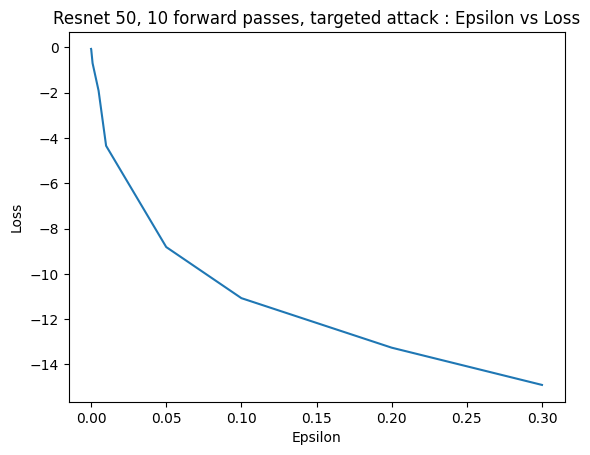

Sur une attaque "targeted"
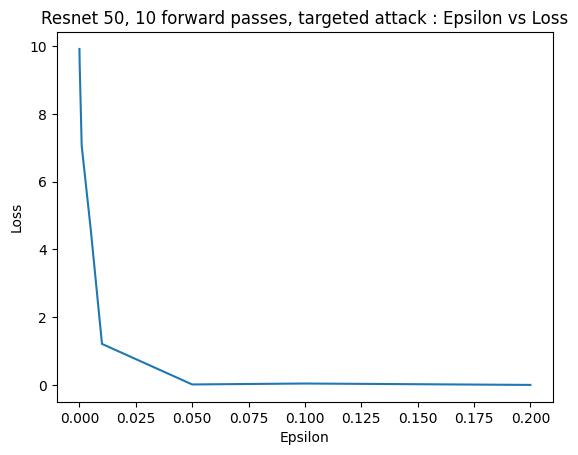

-0.06338801234960556
tensor(0., device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
-0.06338801234960556
tensor(0.2670, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
-0.06338801234960556
tensor(2.6697, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
-0.06338801234960556
tensor(13.3298, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
-0.06338801234960556
tensor(22.2273, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
-0.06338801234960556
tensor(77.0247, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
-0.06338801234960556
tensor(112.4787, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
-0.06338801234960556
tensor(139.5048, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)
-0.06338801234960556
tensor(161.4003, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


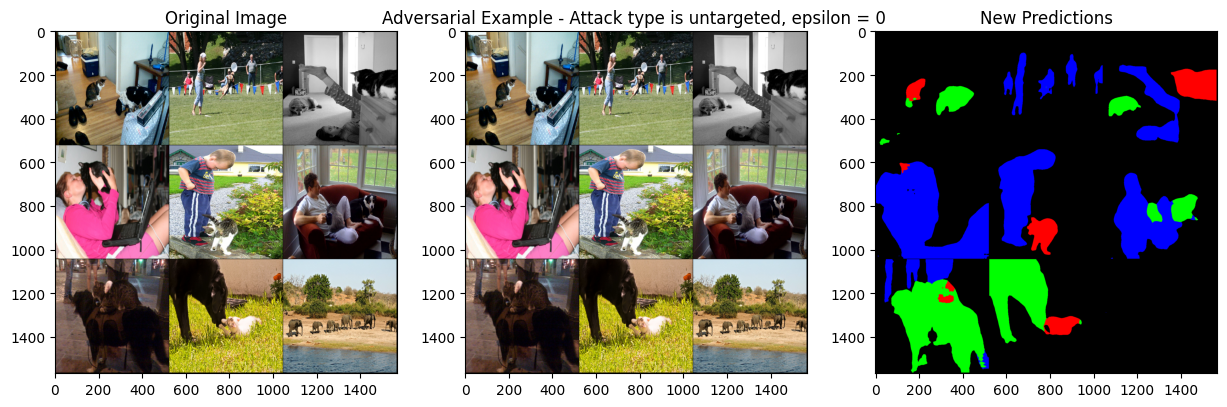

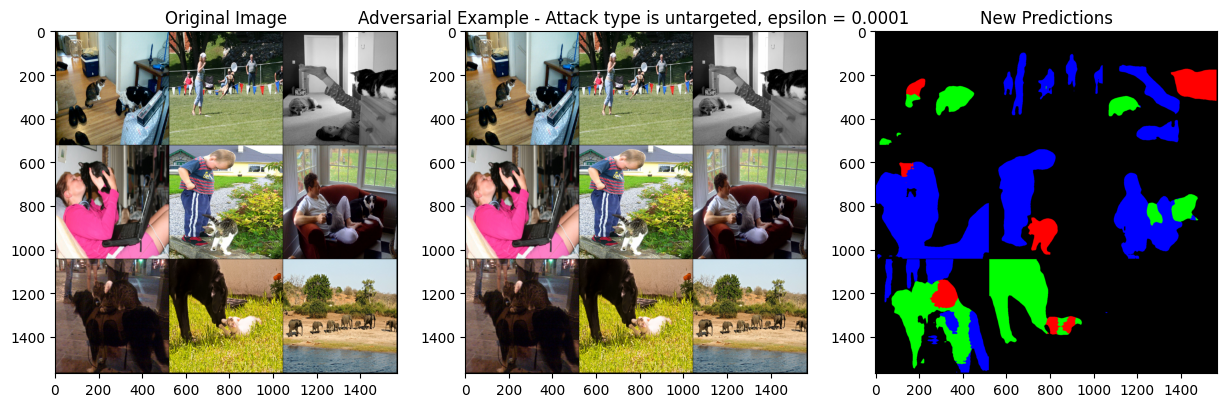

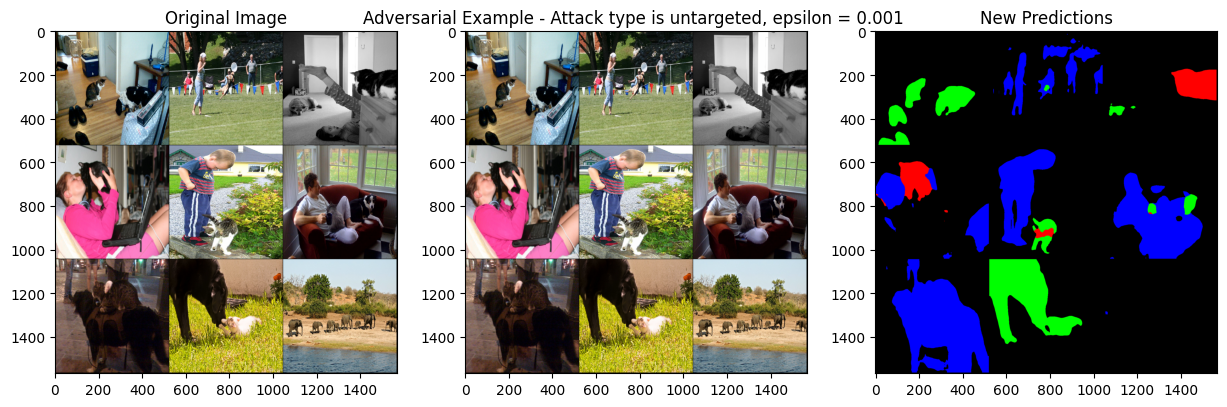

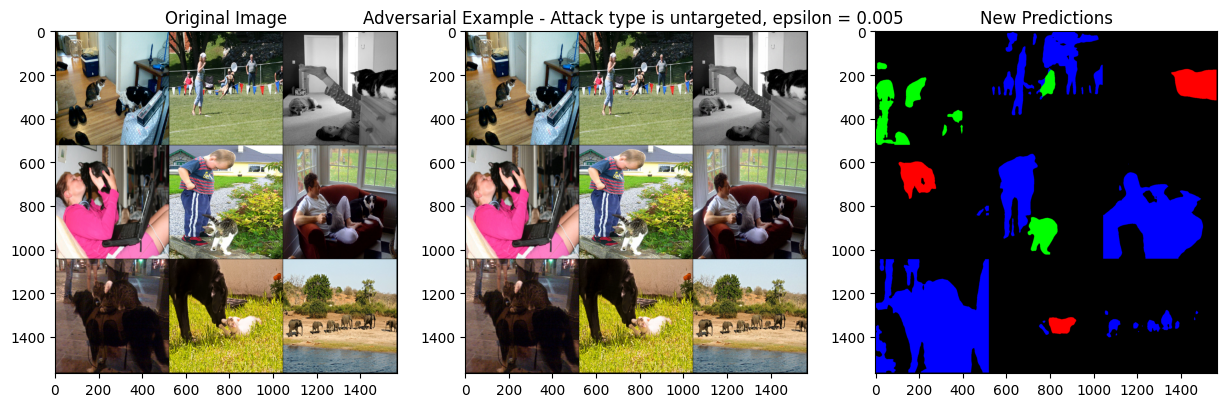

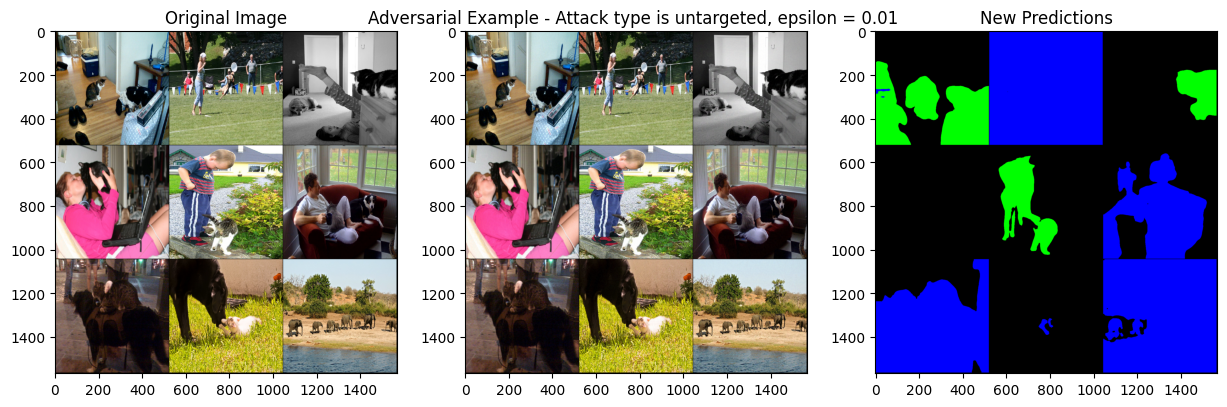

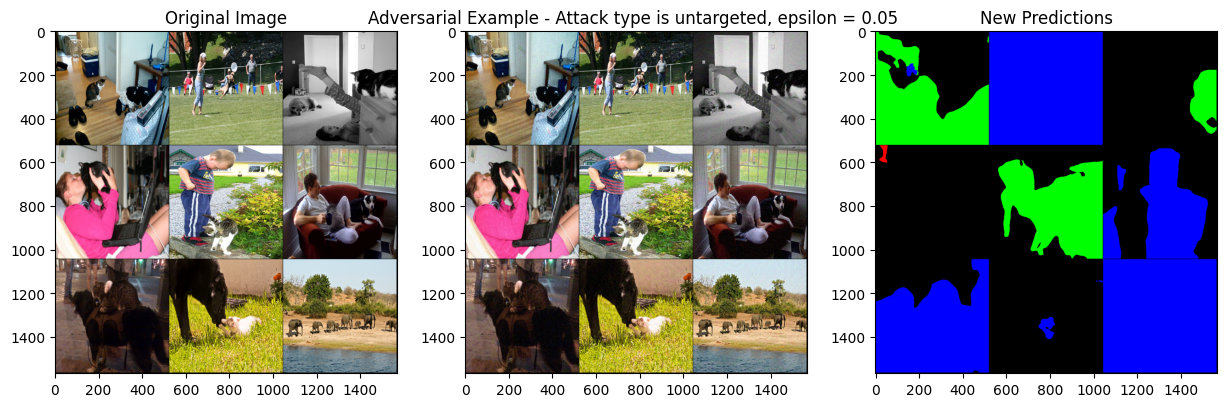

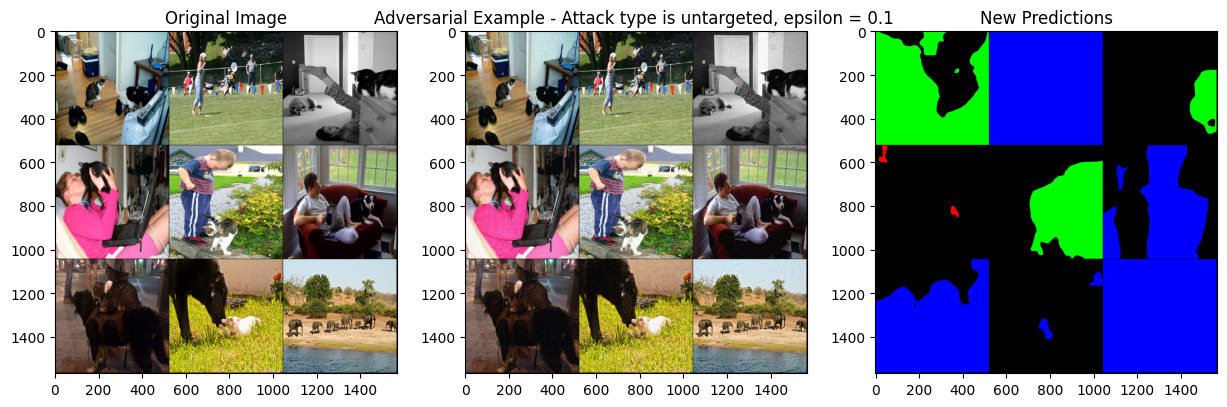

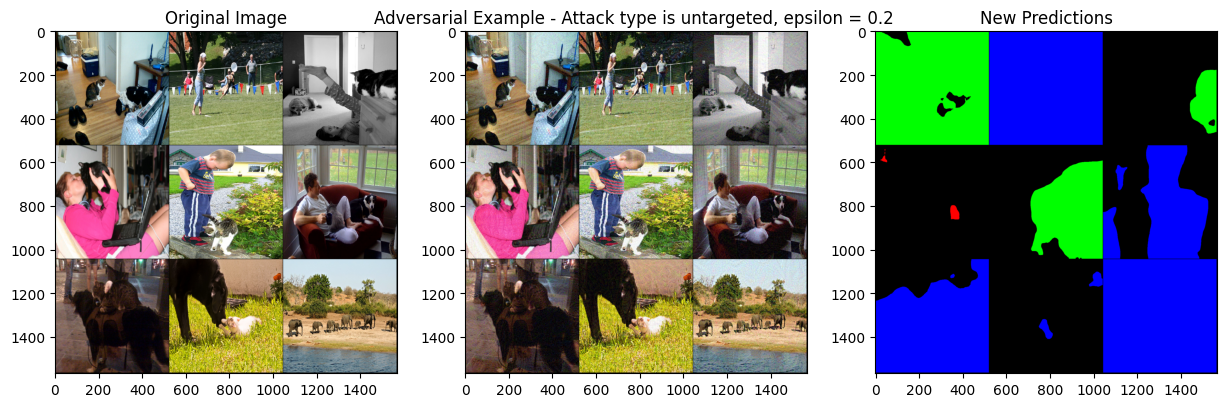

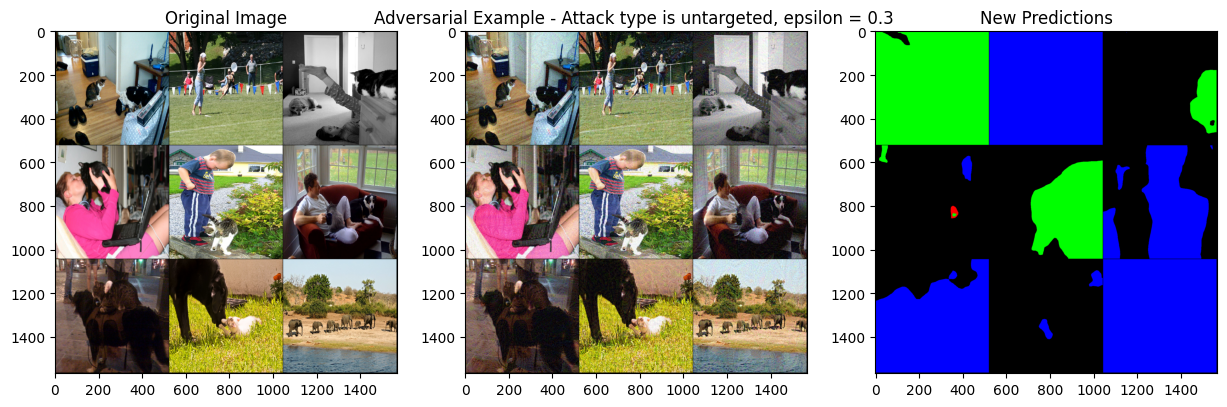

In [ ]:
epsilon_values = [0 , 0.0001 , 0.001 , 0.005 , 0.01 , 0.05 , 0.1 , 0.2 , 0.3 ] #epsilon définit le maximum de bruit qu'on tolère

#choose as targeted or leave null

attack_type = 'untargeted'

attaque = torch.nn.Parameter(torch.zeros_like(img),requires_grad=True)  # we will optimize this tensor called "attaque" so we need its gradients to do a backprop.
optimizer = torch.optim.SGD([attaque], lr=0.01)
num_iterations=10
target_class = 1

epsilon_compare(epsilon_values, attack_type, num_iterations, target_class, attaque, optimizer)

##Question 4 : application à un autre modèle
Pour avoir un modèle comparable on va prendre un autre modèle avec backbone Resnet50, mais cette fois-ci FCN(fully-convoluted network)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth
100%|██████████| 135M/135M [00:01<00:00, 93.0MB/s]


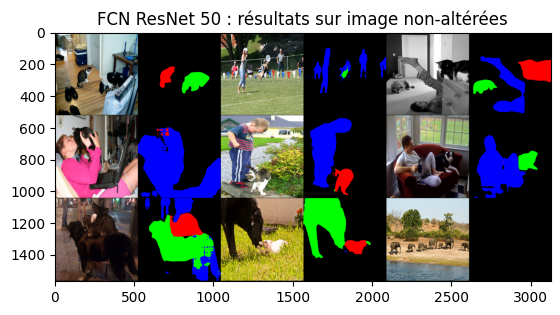

In [ ]:
net2 = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50', pretrained=True)
net2 = net2.eval().to(device)




with torch.no_grad():
  img = img.to(device)
  newpred = net2(normalize(img))["out"] # on prédit des cartes de score de confiance
  newpred = newpred[:,[0,8,12,15],:,:] # on garde background, person, cat et dog
  _,newpred = newpred.max(1) # on prend le meilleur score
# après ça c'est du test pour le resnet mais ça consomme du GPU donc par défaut on va l'ignorer

# visualisation des prédictions : il faut transformer les indices de classes en couleur
pred = torch.zeros(9,3,520,520)
pred[:,0,:,:] = (newpred==1).float() # red for cat
pred[:,1,:,:] = (newpred==2).float() # green for dog
pred[:,2,:,:] = (newpred==3).float() # blue for person

visu = torch.cat([img.cpu(),pred],dim=-1)
visu = torchvision.utils.make_grid(visu,nrow=3)
visu = torch.transpose(torch.transpose(visu, 0, 1),1,2)
plt.imshow(visu.numpy())
plt.title("FCN ResNet 50 : résultats sur image non-altérées")
plt.show()


Dans l'ensemble les prédictions sont plutot bonnes, quoique-moins que le DeepLabV3. On va maintenant entrainer une attaque sur le DeepLabV3 et l'appliquer à ce FCN.

On va essayer une attaque "targeted" avec un epsilon de 0.01 car c'était très efficace sur le deeplab malgré le faible epsilon

In [ ]:
attaque2 = torch.nn.Parameter(torch.zeros_like(img),requires_grad=True)
optimizer2 = torch.optim.SGD([attaque2], lr=0.01)
epsilon2 = 0.01

print(attack_learn(epsilon2, attaque2, optimizer2, attack_type='targeted', num_iterations=10, target_class=1))



0.8742196559906006


On peut ensuite appliquer l'attaque au réseau FCN :

à partir de ce point, notre groupe était complètement à cours de ressource GPU et le CPU est trop limité en mémoire pour faire tourner les réseaux. Nous avons donc écris le code sans pouvoir le tester.

tensor(22.1662, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)


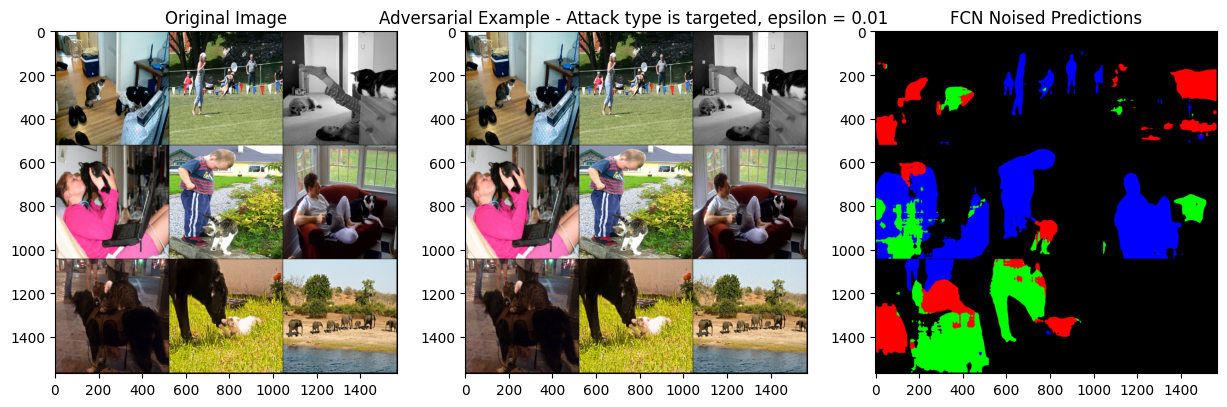

In [ ]:
# Visualize original image
plt.figure(figsize=(15, 5))  # Adjust the figure size for clarity
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(torchvision.utils.make_grid((img), nrow=3).permute(1, 2, 0).cpu().numpy() )# Ensure .cpu() for visualization



# Visualize adversarial example
plt.subplot(1, 3, 2)
plt.title(f"Adversarial Example - Attack type is targeted, epsilon = {epsilon2} ")
print(attaque2.norm())
plt.imshow(torchvision.utils.make_grid(img + attaque2, nrow=3).permute(1, 2, 0).cpu().numpy())

# Visualize new predictions
with torch.no_grad():
    new_preds = net2((normalize(img + attaque2)).to(device))["out"]
    new_preds = new_preds[:, [0, 8, 12, 15], :, :].argmax(1)  # Extract new class predictions

# Convert predictions to RGB for visualization
new_pred_colors = torch.zeros_like(img)  # Start with a blank image, use `x` instead of `img`
new_pred_colors[:, 0, :, :] = (new_preds == 1).float()  # Red for "cat"
new_pred_colors[:, 1, :, :] = (new_preds == 2).float()  # Green for "dog"
new_pred_colors[:, 2, :, :] = (new_preds == 3).float()  # Blue for "person"

plt.subplot(1, 3, 3)
plt.title("FCN Noised Predictions")
plt.imshow(torchvision.utils.make_grid(new_pred_colors, nrow=3).permute(1, 2, 0).cpu().numpy())  # Ensure .cpu() for visualization


L'image est clairement perturbée par ce bruit pourtant invisible, mais prédit quand même dans l'ensemble les bonnes étiquettes. On peut tout de même souligner la disparition totale de l'homme en haut à gauche.

Par ailleurs l'attaque était "targeted" sur l'étiquette chat, ce qui a clairement échoué : Ce réseau ne prédit pas spécialement plus de chats.

##Q5. Apprentissage sur réseaux multiples

On va maintenant essayer de réaliser le même apprentissage mais en faisant un bruit adapté à plusieurs réseaux en même temps. Pour cela, on peut simplement prendre une liste de réseaux avec leurs prédictions supposées, calculer une liste de prédictions bruitées, et sommer les entropies croisées pour obtenir la fonction de perte finale. La descente de gradient se fait ensuite exactement de la même manière.

On va faire ici un bruit "untargeted", car tous les réseaux n'ont pas les mêmes output : certains prédisent des zones (segmentation), d'autres des entitées individuelles, d'autres donnent juste une étiquette pour toute l'image : on ne peut donc pas choisir de cible commune à tous les réseaux.

In [ ]:
#on commence par précalculer les étiquettes

def multiple_z(netList):
  output = []
  for net in netList:
    output.append(net(normalize(img).to(device))["out"])
  return output



def attack_learn_multiple(epsilon, atk_tensor, optimizer, netList, attack_type='targeted', num_iterations=10, target_class=1):
  for i in range(num_iterations):
    ######Calcul de la cross entropy commune

    for i in range(len(netList)):
      # Forward pass with the current perturbation
      Znoised = netList[i](normalize(img + attaque).to(device))["out"]

      z= ZList[i]
      if L in locals():
        L -= F.cross_entropy(Znoised, z)  # Si L est déjà définie localement on ajoute la nouvelle CE
      else:
        L = -F.cross_entropy(Znoised, z)  # Sinon on définie L avec la CE
    # Zero gradients from the previous step

    optimizer.zero_grad()

    # calculates loss gradients and stores them in attaque
    L.backward()

    # Update perturbation based on gradient sign (sign attack)
    # Apply optimization step
    with torch.no_grad():

      atk_tensor.grad = atk_tensor.grad.sign() #On ne garde que le signe du gradient, donc prendre la CE sommée ou moyenne revient au même
      optimizer.step()

      # Clip the perturbation to keep it within an acceptable range (bounded by epsilon)
      atk_tensor.data = torch.clamp(atk_tensor.data, -epsilon, epsilon)

      # Ensure the perturbation stays within valid bounds relative to the original image
      lowbound = -img
      uppbound = 1 - img
      atk_tensor.data = torch.max(torch.min(atk_tensor.data, uppbound), lowbound)
  return L.item()

In [ ]:
netList = [net , net2]
zList = multiple_z(netList)
attaque3 = torch.nn.Parameter(torch.zeros_like(img),requires_grad=True)  # on réinitialise le tenseur d'attaque
optimizer3 = torch.optim.SGD([attaque], lr=0.01)
num_iterations=10

attack_learn_multiple(0.01, attaque3, optimizer3, netList, attack_type='targeted', num_iterations=10, target_class=1)



OutOfMemoryError: CUDA out of memory. Tried to allocate 38.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 30.12 MiB is free. Process 10602 has 14.71 GiB memory in use. Of the allocated memory 14.44 GiB is allocated by PyTorch, and 151.54 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Ce code devrait renvoyer un bruit applicable aux deux réseaux qui les perturberais tous. Néanmoins chaque réseau a des output différents et des visualisations différentes, on ne peut donc pas vraiment comparer les visualisations de manière générale. On peut néanmoins le faire avec les deux ResNet vus précedemment.

Les 15Gb de RAM du GPU gratuit de colab ne permettent pas de charger en simultané deux réseaux différents, nous n'avons donc pas compilé la suite du projet. Le code devrait tout de même fonctionner si il était éxécuté avec plus de ressources.

In [ ]:
# Visualize original image
plt.figure(figsize=(15,5 ))  # Adjust the figure size for clarity




# Visualize adversarial example
plt.subplot(1, 3, 1)
plt.title(f"Adversarial Example - Attack type is untargeted on FCN and deepLabV3, epsilon = {epsilon2} ")
print(attaque.norm())
plt.imshow(torchvision.utils.make_grid(img + attaque3, nrow=3).permute(1, 2, 0).cpu().numpy())



# Visualize DeepLabV3 predictions
with torch.no_grad():
    predsDLV3 = net((normalize(img + attaque3)).to(device))["out"]
    predsDLV3 = predsDLV3[:, [0, 8, 12, 15], :, :].argmax(1)  # Extract new class predictions

# Convert predictions to RGB for visualization
new_pred_colors = torch.zeros_like(img)  # Start with a blank image, use `x` instead of `img`
new_pred_colors[:, 0, :, :] = (predsDLV3 == 1).float()  # Red for "cat"
new_pred_colors[:, 1, :, :] = (predsDLV3 == 2).float()  # Green for "dog"
new_pred_colors[:, 2, :, :] = (predsDLV3 == 3).float()  # Blue for "person"

plt.subplot(1, 3, 2)
plt.title("DeepLabV3 Noised Predictions")
plt.imshow(torchvision.utils.make_grid(new_pred_colors, nrow=3).permute(1, 2, 0).cpu().numpy())  # Ensure .cpu() for visualization



# Visualize FCN predictions
with torch.no_grad():
    predsFCN = net((normalize(img + attaque3)).to(device))["out"]
    predsFCN = predsFCN[:, [0, 8, 12, 15], :, :].argmax(1)  # Extract new class predictions

# Convert predictions to RGB for visualization
new_pred_colors = torch.zeros_like(img)  # Start with a blank image, use `x` instead of `img`
new_pred_colors[:, 0, :, :] = (predsFCN == 1).float()  # Red for "cat"
new_pred_colors[:, 1, :, :] = (predsFCN == 2).float()  # Green for "dog"
new_pred_colors[:, 2, :, :] = (predsFCN == 3).float()  # Blue for "person"

plt.subplot(1, 3, 3)
plt.title("FCN Noised Predictions")
plt.imshow(torchvision.utils.make_grid(new_pred_colors, nrow=3).permute(1, 2, 0).cpu().numpy())  # Ensure .cpu() for visualization


